# TensorFlow 2.0 Text generator on Dante Alighieri's Divine Comedy

Author: **Ivan Bongiorni**, [LinkedIn profile](https://www.linkedin.com/in/ivan-bongiorni-b8a583164/)


This Notebook contains a **text generator RNN** that was trained on the **Divina Commedia** (the *Divine Comedy*) by **Dante Alighieri**. This is a poem written at the beginning of the XII century. It's hard to explain what it represents for Italian culture: it's without any doubt the main pillar of our national literature, one of the building blocks of modern Italian language, and arguably the gratest poem ever. All modern representations of Hell, Purgatory and Heaven derive from this opera.

It's structure is extremely interesting: each verse is composed of 11 syllables, and its rhymes follow an **A-B-A-B** structure. Lot of pattern to be learned! 

In [0]:
import time
import re

import numpy as np
import pandas as pd

%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

from matplotlib import pyplot as plt

# Read file from Colab Notebook
from google.colab import drive
drive.mount('/content/drive')

TensorFlow 2.x selected.
2.1.0-rc1
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
current_path = " [...] /TF_2.0/NLP/text_generator/"

# Read the Divina Commedia
with open(current_path + "DivinaCommedia.txt", 'r', encoding="utf8") as file:
    divina_commedia = file.read()

# Replace rare characters
divina_commedia = divina_commedia.replace("ä", "a")
divina_commedia = divina_commedia.replace("é", "è")
divina_commedia = divina_commedia.replace("ë", "è")
divina_commedia = divina_commedia.replace("Ë", "E")
divina_commedia = divina_commedia.replace("ï", "i")
divina_commedia = divina_commedia.replace("Ï", "I")
divina_commedia = divina_commedia.replace("ó", "ò")
divina_commedia = divina_commedia.replace("ö", "o")
divina_commedia = divina_commedia.replace("ü", "u")

divina_commedia = divina_commedia.replace("(", "-")
divina_commedia = divina_commedia.replace(")", "-")
divina_commedia = divina_commedia.replace("[", "")
divina_commedia = divina_commedia.replace("]", "")

divina_commedia = re.sub(r'[0-9]+', '', divina_commedia)
divina_commedia = divina_commedia.replace(" \n", "\n")

In [0]:
# Check lenght of text
print(len(divina_commedia))

551697


I will now extract the set of unique characters, and create a dictionary for vectorization of text. In order to feed the text into a Neural Network, I must turn each character into a number.

In [0]:
# Store unique characters into a dict with numerical encoding
unique_chars = list(set(divina_commedia))
unique_chars.sort()  # to make sure you get the same encoding at each run

# Store them in a dict, associated with a numerical index
char2idx = { char[1]: char[0] for char in enumerate(unique_chars) }


In [0]:
print(len(char2idx))

63


In [0]:
char2idx

{'\n': 0,
 ' ': 1,
 '!': 2,
 '"': 3,
 "'": 4,
 ',': 5,
 '-': 6,
 '.': 7,
 ':': 8,
 ';': 9,
 '?': 10,
 'A': 11,
 'B': 12,
 'C': 13,
 'D': 14,
 'E': 15,
 'F': 16,
 'G': 17,
 'H': 18,
 'I': 19,
 'L': 20,
 'M': 21,
 'N': 22,
 'O': 23,
 'P': 24,
 'Q': 25,
 'R': 26,
 'S': 27,
 'T': 28,
 'U': 29,
 'V': 30,
 'X': 31,
 'Z': 32,
 'a': 33,
 'b': 34,
 'c': 35,
 'd': 36,
 'e': 37,
 'f': 38,
 'g': 39,
 'h': 40,
 'i': 41,
 'j': 42,
 'l': 43,
 'm': 44,
 'n': 45,
 'o': 46,
 'p': 47,
 'q': 48,
 'r': 49,
 's': 50,
 't': 51,
 'u': 52,
 'v': 53,
 'x': 54,
 'y': 55,
 'z': 56,
 'È': 57,
 'à': 58,
 'è': 59,
 'ì': 60,
 'ò': 61,
 'ù': 62}

Once I have a dictionary that maps each characted with its respective numerical index, I can process the whole corpus.

In [0]:
def numerical_encoding(text, char_dict):
    """ Text to list of chars, to np.array of numerical idx """
    chars_list = [ char for char in text ]
    chars_list = [ char_dict[char] for char in chars_list ]
    chars_list = np.array(chars_list)
    return chars_list


In [0]:
# Let's see what the first line will look like
print("{}".format(divina_commedia[276:311]))
print("\nbecomes:")
print(numerical_encoding(divina_commedia[276:311], char2idx))

Nel mezzo del cammin di nostra vita

becomes:
[22 37 43  1 44 37 56 56 46  1 36 37 43  1 35 33 44 44 41 45  1 36 41  1
 45 46 50 51 49 33  1 53 41 51 33]


## RNN dataprep

I need to generate a set of stacked input sequences. My goal is to train a Neural Network to find a mapping between an input sequence and an output sequence of equal length, in which each character is shifted left of one position.

For example, the first verse:

> Nel mezzo del cammin di nostra vita

would be translated in a train sequence as:

`Nel mezzo del cammin di nostra vit`

be associated with the target sequence:

`el mezzo del cammin di nostra vita`

The following function is a preparatory step for that. More generally, given a sequence:

```
A B C D E F G H I
```

and assuming input sequences of length 5, it will generate a matrix like:

```
A B C D E
B C D E F
C D E F G
D E F G H
E F G H I
```

I will save that matrix as it is in .csv format, to use it to train the Language Generator later.
The split between train and target sets will be as:

```
 Train:           Target:
                 
A B C D E        B C D E F
B C D E F        C D E F G
C D E F G        D E F G H
D E F G H        E F G H I
                 
```

Train and target sets are fundamentally the same matrix, with the train having the last row removed, and the target set having the first removed.

In [0]:
# Apply it on the whole Comedy
encoded_text = numerical_encoding(divina_commedia, char2idx)

In [0]:
def get_text_matrix(sequence, len_input):
    
    # create empty matrix
    X = np.empty((len(sequence)-len_input, len_input))
    
    # fill each row/time window from input sequence
    for i in range(X.shape[0]):
        X[i,:] = sequence[i : i+len_input]
        
    return X

In [0]:
text_matrix = get_text_matrix(encoded_text, 100)

In [0]:
print(text_matrix.shape)

(551597, 100)


In [0]:
print("100th train sequence:\n")
print(text_matrix[ 100, : ])
print("\n\n100th target sequence:\n")
print(text_matrix[ 101, : ])

100th train sequence:

[45. 37.  1. 37.  1. 47. 52. 45. 41. 44. 37. 45. 51. 41.  1. 36. 37.  4.
  1. 53. 41. 56. 41.  1. 37.  1. 36. 37.  4.  1. 44. 37. 49. 41. 51. 41.
  1. 37.  1. 47. 49. 37. 44. 41.  1. 36. 37.  1. 43. 37.  1. 53. 41. 49.
 51. 62.  7.  1. 13. 46. 44. 41. 45. 35. 41. 33.  1. 41. 43.  1. 35. 33.
 45. 51. 46.  1. 47. 49. 41. 44. 46.  1. 36. 37.  1. 43. 33.  1. 47. 49.
 41. 44. 33.  1. 47. 33. 49. 51. 37.  1.]


100th target sequence:

[37.  1. 37.  1. 47. 52. 45. 41. 44. 37. 45. 51. 41.  1. 36. 37.  4.  1.
 53. 41. 56. 41.  1. 37.  1. 36. 37.  4.  1. 44. 37. 49. 41. 51. 41.  1.
 37.  1. 47. 49. 37. 44. 41.  1. 36. 37.  1. 43. 37.  1. 53. 41. 49. 51.
 62.  7.  1. 13. 46. 44. 41. 45. 35. 41. 33.  1. 41. 43.  1. 35. 33. 45.
 51. 46.  1. 47. 49. 41. 44. 46.  1. 36. 37.  1. 43. 33.  1. 47. 49. 41.
 44. 33.  1. 47. 33. 49. 51. 37.  1. 43.]


# Architecture

At this point, I can specify the RNN architecture with all its hyperparameters. An `Embedding()` layer will first learn a representation of each character; the sequence of chracters embedding will then be fed into an `LSTM()` layer, that will extract information from their sequence; `Dense()` layers at the end will produce the next character prediction.

The Network is structured to be fed with batches of data of fixed size.

In [0]:
# size of vocabulary
vocab_size = len(char2idx)

# size of mini batches during training
batch_size = 100

# size of training subset at each epoch
subset_size = batch_size * 100

# vector size of char embeddings
embedding_size = 250

len_input = 1000   # 200

hidden_size = 250  # for Dense() layers

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.activations import elu, relu, softmax

In [0]:
seq2seq = Sequential([
    Embedding(vocab_size, embedding_size,
              batch_input_shape=(batch_size, None)),
    
    LSTM(len_input, return_sequences = True),
    
    Dense(hidden_size, activation = relu), 
    
    Dense(vocab_size)
])

seq2seq.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (100, None, 250)          15750     
_________________________________________________________________
lstm (LSTM)                  (100, None, 1000)         5004000   
_________________________________________________________________
dense (Dense)                (100, None, 250)          250250    
_________________________________________________________________
dense_1 (Dense)              (100, None, 63)           15813     
Total params: 5,285,813
Trainable params: 5,285,813
Non-trainable params: 0
_________________________________________________________________


In [0]:
n_epochs = 100

learning_rate = 0.0001
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

In [0]:
# This is an Autograph function
# its decorator makes it a TF op - i.e. much faster
@tf.function
def train_on_batch(x, y):
    with tf.GradientTape() as tape:
        current_loss = tf.reduce_mean(
            tf.keras.losses.sparse_categorical_crossentropy(
                y, seq2seq(x), from_logits = True))
    gradients = tape.gradient(current_loss, seq2seq.trainable_variables)
    optimizer.apply_gradients(zip(gradients, seq2seq.trainable_variables))
    return current_loss

In [0]:
loss_history = []

for epoch in range(n_epochs):
    start = time.time()
    
    # Take subsets of train and target
    sample = np.random.randint(0, text_matrix.shape[0]-1, subset_size)
    sample_train = text_matrix[ sample , : ]
    sample_target = text_matrix[ sample+1 , : ]
    
    for iteration in range(sample_train.shape[0] // batch_size):
        start = iteration * batch_size
        x = sample_train[ start:start+batch_size , : ]
        y = sample_target[ start:start+batch_size , : ]

        current_loss = train_on_batch(x, y)
        loss_history.append(current_loss)
    
    print("{}.  \t  Loss: {}  \t  Time: {}ss".format(
        epoch+1, current_loss.numpy(), round(time.time()-start, 2)))

1.  	  Loss: 3.111814022064209  	  Time: 1578747534.28ss
2.  	  Loss: 2.937624216079712  	  Time: 1578747541.8ss
3.  	  Loss: 2.6059911251068115  	  Time: 1578747549.32ss
4.  	  Loss: 2.442699670791626  	  Time: 1578747556.83ss
5.  	  Loss: 2.336099147796631  	  Time: 1578747564.33ss
6.  	  Loss: 2.273846387863159  	  Time: 1578747571.85ss
7.  	  Loss: 2.2103261947631836  	  Time: 1578747579.38ss
8.  	  Loss: 2.1668601036071777  	  Time: 1578747586.89ss
9.  	  Loss: 2.1551244258880615  	  Time: 1578747594.4ss
10.  	  Loss: 2.09932017326355  	  Time: 1578747601.94ss
11.  	  Loss: 2.076141119003296  	  Time: 1578747609.51ss
12.  	  Loss: 2.0864453315734863  	  Time: 1578747617.05ss
13.  	  Loss: 2.0433664321899414  	  Time: 1578747624.58ss
14.  	  Loss: 2.0631515979766846  	  Time: 1578747632.12ss
15.  	  Loss: 2.000927448272705  	  Time: 1578747639.65ss
16.  	  Loss: 1.9632011651992798  	  Time: 1578747647.17ss
17.  	  Loss: 1.976094365119934  	  Time: 1578747654.7ss
18.  	  Loss: 1.948

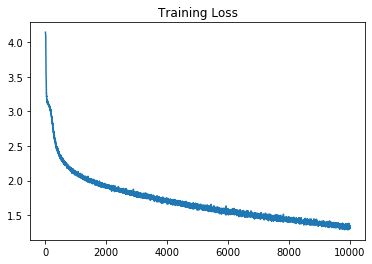

In [0]:
plt.plot(loss_history)
plt.title("Training Loss")
plt.show()

In [0]:
seq2seq.save(current_path + "models/text_generator_RNN_00.h5")

# Text Generation

At this point, let's check how the model generates text. In order to do it, I must make some changes to my RNN architecture above.

First, I must change the fixed batch size. After training, I want to feed just one sentence into my Network to make it continue the character sequence. I will feed a string into the model, make it predict the next character, update the input sequence, and repeat the process until a long generated text is obtained. Because of this, the succession of input sequences is now different from training session, in which portions of text were sampled randomly. I now have to set `stateufl = True` in the `LSTM()` layer, so that each LSTM cell will keep in memory the internal state from the previous sequence. With this I hope the model will better remember sequential information while generating text.

I will instantiate a new `generator` RNN with these new features, and transfer the trained weights of my `RNN` into it.

In [0]:
generator = Sequential([
    Embedding(vocab_size, embedding_size,
              batch_input_shape=(1, None)),
    
    LSTM(len_input, return_sequences = True, stateful=True),
    
    Dense(hidden_size, activation = relu), 
    
    Dense(vocab_size)
])

generator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (1, None, 250)            15750     
_________________________________________________________________
lstm_3 (LSTM)                (1, None, 1000)           5004000   
_________________________________________________________________
dense_4 (Dense)              (1, None, 250)            250250    
_________________________________________________________________
dense_5 (Dense)              (1, None, 63)             15813     
Total params: 5,285,813
Trainable params: 5,285,813
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Import trained weights from RNN to generator
generator.set_weights(seq2seq.get_weights())

In [0]:
def generate_text(start_string, num_generate = 1000, temperature = 1.0):
    
    # Vectorize input string
    input_eval = [char2idx[s] for s in start_string]  
    input_eval = tf.expand_dims(input_eval, 0)
    
    text_generated = [] # List to append predicted chars 
    
    idx2char = { v: k for k, v in char2idx.items() }  # invert char-index mapping
    
    generator.reset_states()
    
    for i in range(num_generate):
        predictions = generator(input_eval)
        predictions = tf.squeeze(predictions, 0)
        
        # sample next char based on distribution and temperature
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
        
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2char[predicted_id])
        
    return (start_string + ''.join(text_generated))


(This function is based on [this tutorial](https://www.tensorflow.org/tutorials/text/text_generation).)

In [0]:
# Let's feed the first lines:
start_string = """
Nel mezzo del cammin di nostra vita
mi ritrovai per una selva oscura,
chè la diritta via era smarrita.

"""

for t in [0.1, 0.5, 1.0, 1.5, 2]:
    print("####### TEXT GENERATION - temperature = {}\n".format(t))
    print(generate_text(start_string = start_string, num_generate = 1000, temperature = 1.0))
    print("\n\n\n")

####### TEXT GENERATION - temperature = 0.1


Nel mezzo del cammin di nostra vita
mi ritrovai per una selva oscura,
chè la diritta via era smarrita.

Ma come scopinsi, ma nostra parve:
da cove già, leggendo e suo cammino
nel fambo che di sè Virgilla è vuope!

Io quando per questo cader levando,
ivi un grazio suover ben fam ditti,
sì come sarei il nome dire; che nullo
sen la man del templasse lo spondo
che non veder, sì piacer sù tembiante.

Masiziava là si converse a fetto:
sì com'om com'amor siamentia mai;
non ti veggia con la somalina essa.

Ondo bella è baladoso e 'Sbecchi
anime annava il dabbrosco sol trova,
per lo non saede inde mi divisia,
e fantue punge lue verso mi racco,

dinanzi a era allor si volme amori,
la rimanebbe col sì al pene detto,
ch'apparò convien che tuo veduti fanno.

E contrui al figliuol divina e bestie
li ostre spiriti che 'l verco secca
proverene a ciò che 'ntrava e per ristei,
prescosse scuole, per le genti schieri,
se per lo punto quell'anima truva,
nabitan

The best generation is, IMHO, the one with `temperature = 1.5`. The sentences of course do not make sense, but it's amazing that such a simple model could achieve similar results, and generate absolutely Dante-esque text with just ~40 minutes of GPU training.

Many things could be done at this point:



*   Try fancier architectures, such as seq2seq. (I must say though that stacked RNNs didn't provide better results during prototyping.)
*   Try Attention models.
*   Longer training.
*   Adversarial training.

I'll try a lot of these techniques, alone and combined. My goal is to make a model that can learn the amazing structure of syllables and rhymes of the whole Comedy.



### Sources

The main source I used to learn to implement an RNN text generator is [this tutorial on the official TensorFlow website](https://www.tensorflow.org/tutorials/text/text_generation).